In [1]:
#Import required libraries

import argparse
import gym
import numpy as np
from itertools import count
from collections import namedtuple
import matplotlib.pyplot as plt
from collections import deque
from scipy.special import softmax
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Without Baseline

## Neural Network

In [3]:
class ReinforcePolicyT1(nn.Module):
  def __init__(self, input_dim, num_actions, hidden_dim = 32):
    super(ReinforcePolicyT1, self).__init__()
    self.input_dim = input_dim
    self.num_actions = num_actions
    self.hidden_dim = hidden_dim
    self.fc1 = nn.Linear(self.input_dim, self.hidden_dim)
    self.fc2 = nn.Linear(self.hidden_dim, self.num_actions)

  def forward(self, x):
    x1 = F.relu(self.fc1(x))
    # print(x)
    x2 = F.softmax(self.fc2(x1), dim=0)
    # print(x)
    return x2

  def get_action(self, probs):
    # probs = probs.detach().cpu().numpy()
    action = np.random.choice([i for i in range(self.num_actions)], p=probs.detach().numpy())
    log_prob = torch.log(probs[action])
    return action, log_prob

In [4]:
eps = np.finfo(np.float32).eps.item()
eps

1.1920928955078125e-07

In [5]:
class ReinforceAgentT1:
  def __init__(self, env, gamma = 0.99, learning_rate = 1e-2, seed = 0, hidden_dim = 32):
    self.num_states = env.observation_space.shape[0]
    self.num_actions = env.action_space.n
    self.hidden_dim = hidden_dim
    self.policy = ReinforcePolicyT1(self.num_states, self.num_actions, self.hidden_dim)
    self.learning_rate = learning_rate
    self.gamma = gamma
    self.seed = seed
    self.optimizer = torch.optim.Adam(self.policy.parameters(), lr=self.learning_rate)
    torch.manual_seed(self.seed)
    torch.cuda.manual_seed(self.seed)
    np.random.seed(self.seed)
    random.seed(self.seed)

  def update(self, rewards_list, log_prob_list):
    score = 0
    rev_rewards_list = rewards_list[::-1]
    num_steps = len(rewards_list)
    discounted_rewards = []

    for i in range(num_steps):
      score = score*self.gamma + rev_rewards_list[i]
      discounted_rewards.append(score)

    discounted_rewards = torch.tensor(discounted_rewards[::-1])
    discounted_rewards = (discounted_rewards - discounted_rewards.mean()) / (discounted_rewards.std() + eps)

    loss_list = []
    for log_prob, Gt in zip(log_prob_list, discounted_rewards):
        loss_list.append(-log_prob * Gt)

    loss = torch.stack(loss_list).sum()
    self.optimizer.zero_grad()
    loss.backward()
    self.optimizer.step()

In [6]:
def train_vanilla(env, agent, num_episodes = 1000, seed = 0, max_steps = 500):
  rewards_per_ep = []
  scores_window = deque(maxlen=100)

  for episode in range(num_episodes):
    state = env.reset(seed = seed)
    log_prob_list = []
    rewards_list = []
    # print(f"Episode {episode}")

    for i in range(max_steps):
      probs = agent.policy(torch.Tensor(state))
      action, log_prob = agent.policy.get_action(probs)
      # print(action)
      # print(log_prob)
      next_state, reward, done, _ = env.step(action)
      rewards_list.append(reward)
      log_prob_list.append(log_prob)
      state = next_state

      if done:
        break

    # print(rewards_list)
    total_reward = sum(rewards_list)
    rewards_per_ep.append(total_reward)
    agent.update(rewards_list, log_prob_list)
    scores_window.append(total_reward)

    # if episode == 5:
    #   break

    print('\rEpisode {}\tScore: {:.2f}'.format(episode, total_reward), end="")

    if episode % 100 == 0:
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(episode, np.mean(scores_window)))

        # if np.mean(scores_window)>=env_threshold:
        #     print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(episode, np.mean(scores_window)))
        #     break

  return rewards_per_ep

# With Baseline


In [7]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
eps = np.finfo(np.float32).eps.item()
# eps

In [8]:
class ReinforcePolicyT2(nn.Module):
  def __init__(self, input_dim, num_actions, hidden_dim = 32): #32
    super(ReinforcePolicyT2, self).__init__()
    self.input_dim = input_dim
    self.num_actions = num_actions
    self.hidden_dim = hidden_dim
    self.fc1 = nn.Linear(self.input_dim, self.hidden_dim)
    self.fc2 = nn.Linear(self.hidden_dim, self.num_actions)

  def forward(self, x):
    x = F.relu(self.fc1(x))
    x = F.softmax(self.fc2(x), dim=0)
    return x

  def get_action(self, probs):
    # probs = probs.detach().cpu().numpy()
    action = np.random.choice([i for i in range(self.num_actions)], p=probs.detach().numpy())
    log_prob = torch.log(probs[action])
    return action, log_prob

In [9]:
class Critic(nn.Module):
  def __init__(self, input_dim, hidden_dim = 16): #16
    super(Critic, self).__init__()
    self.input_dim = input_dim
    self.output_dim = 1
    self.hidden_dim = hidden_dim
    self.fc1 = nn.Linear(self.input_dim, self.hidden_dim)
    self.fc2 = nn.Linear(self.hidden_dim, self.output_dim)

  def forward(self, x):
    x = F.relu(self.fc1(x))
    x = self.fc2(x)
    return x # returns value of that state

In [10]:
class ReinforceAgentT2:
  def __init__(self, env, gamma = 0.99, learning_rate_actor = 1e-2, learning_rate_critic = 1e-2, seed = 0):
    self.num_states = env.observation_space.shape[0]
    self.num_actions = env.action_space.n
    self.policy = ReinforcePolicyT2(self.num_states, self.num_actions)
    self.critic = Critic(self.num_states)
    self.learning_rate_actor = learning_rate_actor
    self.learning_rate_critic = learning_rate_critic
    self.gamma = gamma
    self.seed = seed
    self.optimizer_actor = torch.optim.Adam(self.policy.parameters(), lr=self.learning_rate_actor)
    self.optimizer_critic = torch.optim.Adam(self.critic.parameters(), lr=self.learning_rate_critic)
    torch.manual_seed(self.seed)
    torch.cuda.manual_seed(self.seed)
    np.random.seed(self.seed)
    random.seed(self.seed)
    # self.loss_criterion = nn.CrossEntropyLoss()

  def update(self, rewards_list, log_prob_list, value_list, next_values_list):

    ## actor update
    score = 0
    rev_rewards_list = rewards_list[::-1]
    num_steps = len(rewards_list)
    discounted_rewards = []
    delta_list = []

    for i in range(num_steps):
      # actor
      score = score*self.gamma + rev_rewards_list[i]
      discounted_rewards.append(score)

    discounted_rewards = torch.tensor(discounted_rewards[::-1])
    discounted_rewards = (discounted_rewards - discounted_rewards.mean()) / (discounted_rewards.std() + eps)

    actor_loss_list = []
    for log_prob, Gt, value in zip(log_prob_list, discounted_rewards, value_list):
        actor_loss_list.append(-log_prob * (Gt - value))

    actor_loss = torch.stack(actor_loss_list).sum()
    self.optimizer_actor.zero_grad()
    actor_loss.backward(retain_graph = True)
    self.optimizer_actor.step()

    target = []
    with torch.no_grad():
      for i in range(num_steps):
        target.append(rewards_list[i] + self.gamma*next_values_list[i])
    target = torch.tensor(target, requires_grad = False)
    value_list = torch.tensor(value_list, requires_grad = True)
    critic_loss = F.mse_loss(value_list, target)
    self.optimizer_critic.zero_grad()
    critic_loss.backward(retain_graph = True)
    self.optimizer_critic.step()

In [11]:
def train(env, agent, num_episodes = 1000, seed = 0, max_steps = 500):
  rewards_per_ep = []
  scores_window = deque(maxlen=20)

  for episode in range(num_episodes):
    state = env.reset(seed = seed)
    log_prob_list = []
    rewards_list = []
    value_list =[]
    next_state_values = []
    # print(f"Episode {episode}")

    for i in range(max_steps):
      probs = agent.policy(torch.Tensor(state))
      action, log_prob = agent.policy.get_action(probs)
      value = agent.critic(torch.Tensor(state))
      # print(action)
      # print(log_prob)
      next_state, reward, done, _ = env.step(action)
      next_value = agent.critic(torch.Tensor(next_state))
      rewards_list.append(reward)
      log_prob_list.append(log_prob)
      value_list.append(value)
      next_state_values.append(next_value)
      state = next_state

      if done:
        break

    # print(rewards_list)
    total_reward = sum(rewards_list)
    rewards_per_ep.append(total_reward)
    agent.update(rewards_list, log_prob_list, value_list, next_state_values)
    scores_window.append(total_reward)

    # if episode == 5:
    #   break

    print('\rEpisode {}\tScore: {:.2f}'.format(episode, total_reward), end="")

    if episode % 20 == 0:
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(episode, np.mean(scores_window)))

        # if np.mean(scores_window)>=env_threshold:
        #     print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(episode, np.mean(scores_window)))
        #     break

  return rewards_per_ep

## Multiple Runs

In [12]:
no_of_eps = 500

In [16]:
reward_avgs = []

for i in [5,6,7,11,50]:
    seed = i
    env = gym.make('CartPole-v1')
    agent = ReinforceAgentT2(env, learning_rate_critic = 5e-3)
    # torch.autograd.set_detect_anomaly(True)
    reward = train(env, agent, num_episodes=no_of_eps, seed = i)
    reward_avgs.append(np.array(reward))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym

Episode 0	Average Score: 10.00
Episode 20	Average Score: 27.00
Episode 40	Average Score: 34.75
Episode 60	Average Score: 55.05
Episode 80	Average Score: 99.10
Episode 100	Average Score: 129.50
Episode 120	Average Score: 324.35
Episode 140	Average Score: 359.90
Episode 160	Average Score: 403.20
Episode 180	Average Score: 489.65
Episode 200	Average Score: 448.35
Episode 220	Average Score: 500.00
Episode 240	Average Score: 429.00
Episode 260	Average Score: 489.10
Episode 280	Average Score: 500.00
Episode 300	Average Score: 500.00
Episode 320	Average Score: 500.00
Episode 340	Average Score: 477.80
Episode 360	Average Score: 487.55
Episode 380	Average Score: 478.95
Episode 400	Average Score: 465.90
Episode 420	Average Score: 483.05
Episode 440	Average Score: 500.00
Episode 460	Average Score: 489.00
Episode 480	Average Score: 481.80
Episode 0	Average Score: 9.00
Episode 20	Average Score: 27.35
Episode 40	Average Score: 45.45
Episode 60	Average Score: 98.25
Episode 80	Average Score: 260.85
Ep

Cartpole wiht baseline: regret = 65617.40000000001


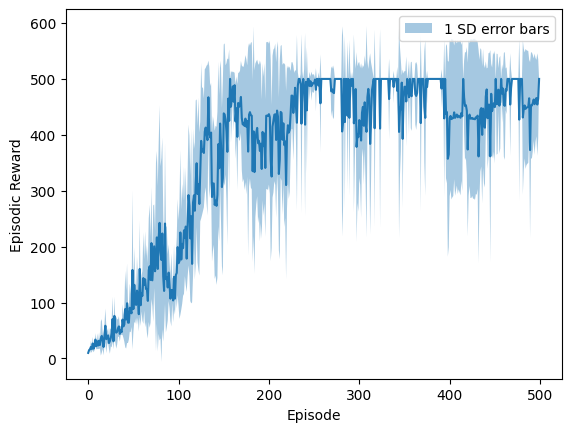

In [18]:
reward_avgs_b = np.array(reward_avgs)
reward_std_b = np.std(reward_avgs_b, axis=0)
reward_avgs_b = np.mean(reward_avgs_b, axis=0)
best = np.ones(no_of_eps)*500
regret_b = np.sum(best-reward_avgs_b)
print(f"Cartpole wiht baseline: regret = {regret_b}")

plt.figure()
plt.plot(reward_avgs_b)
plt.fill_between(np.array(range(no_of_eps)), reward_avgs_b - reward_std_b, reward_avgs_b + reward_std_b, alpha=0.4, label='1 SD error bars')
plt.xlabel('Episode')
plt.ylabel('Episodic Reward')
plt.legend()
plt.savefig('baseline_cartpole')
plt.show()

In [19]:
reward_avgs_v = []

for i in [5,6,7,11,50]:
    seed = i
    env = gym.make('CartPole-v1')
    agent = ReinforceAgentT1(env, learning_rate = 5e-3)
    # torch.autograd.set_detect_anomaly(True)
    reward = train_vanilla(env, agent, num_episodes=no_of_eps, seed = i)
    reward_avgs_v.append(np.array(reward))

Episode 0	Average Score: 10.00
Episode 100	Average Score: 42.46
Episode 200	Average Score: 202.22
Episode 300	Average Score: 223.23
Episode 400	Average Score: 424.87
Episode 0	Average Score: 9.00
Episode 100	Average Score: 55.38
Episode 200	Average Score: 250.79
Episode 300	Average Score: 422.95
Episode 400	Average Score: 480.76
Episode 0	Average Score: 11.00
Episode 100	Average Score: 37.77
Episode 200	Average Score: 140.58
Episode 300	Average Score: 275.94
Episode 400	Average Score: 473.97
Episode 0	Average Score: 9.00
Episode 100	Average Score: 48.18
Episode 200	Average Score: 204.66
Episode 300	Average Score: 409.71
Episode 400	Average Score: 488.38
Episode 0	Average Score: 11.00
Episode 100	Average Score: 55.39
Episode 200	Average Score: 302.01
Episode 300	Average Score: 406.18
Episode 400	Average Score: 407.39
Episode 499	Score: 500.00

Cartpole regret = 96623.0


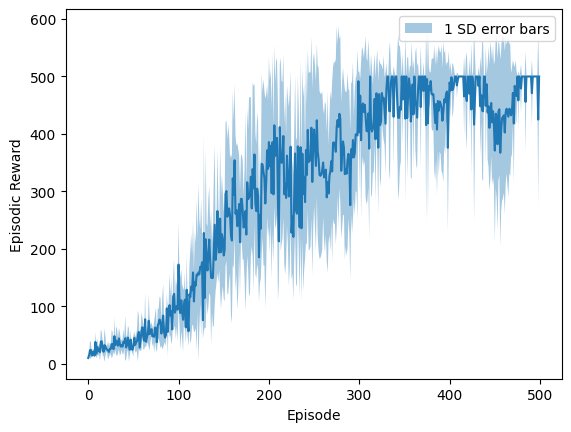

In [20]:
reward_avgs = np.array(reward_avgs_v)
reward_std = np.std(reward_avgs, axis=0)
reward_avgs = np.mean(reward_avgs, axis=0)
best = np.ones(no_of_eps)*500
regret = np.sum(best-reward_avgs)
print(f"Cartpole regret = {regret}")

plt.figure()
plt.plot(reward_avgs)
plt.fill_between(np.array(range(no_of_eps)), reward_avgs - reward_std, reward_avgs + reward_std, alpha=0.4, label='1 SD error bars')
plt.xlabel('Episode')
plt.ylabel('Episodic Reward')
plt.legend()
plt.savefig('vanilla_cartpole')
plt.show()

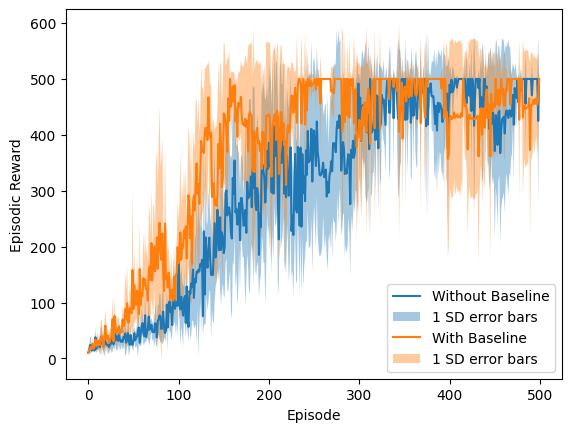

In [21]:
plt.figure()
plt.plot(reward_avgs, label = "Without Baseline")
plt.fill_between(np.array(range(no_of_eps)), reward_avgs - reward_std, reward_avgs + reward_std, alpha=0.4, label='1 SD error bars')
plt.plot(reward_avgs_b, label = "With Baseline")
plt.fill_between(np.array(range(no_of_eps)), reward_avgs_b - reward_std_b, reward_avgs_b + reward_std_b, alpha=0.4, label='1 SD error bars')
plt.xlabel('Episode')
plt.ylabel('Episodic Reward')
plt.legend()
plt.savefig('both_cartpole')
plt.show()

# Acrobot

In [22]:
no_of_eps = 500

In [23]:
reward_avgs_va = []

for i in [0,1,4,5,6]:
    seed = i
    env = gym.make('Acrobot-v1')
    # env.seed(0)
    agent = ReinforceAgentT1(env, learning_rate = 5e-3, hidden_dim = 32)
    # torch.autograd.set_detect_anomaly(True)
    reward = train_vanilla(env, agent, num_episodes=no_of_eps, seed = i)
    reward_avgs_va.append(np.array(reward))

Episode 0	Average Score: -500.00
Episode 100	Average Score: -214.83
Episode 200	Average Score: -159.25
Episode 300	Average Score: -166.62
Episode 400	Average Score: -139.67
Episode 0	Average Score: -500.00
Episode 100	Average Score: -431.14
Episode 200	Average Score: -268.03
Episode 300	Average Score: -228.13
Episode 400	Average Score: -127.61
Episode 0	Average Score: -500.00
Episode 100	Average Score: -227.05
Episode 200	Average Score: -134.55
Episode 300	Average Score: -117.54
Episode 400	Average Score: -106.10
Episode 0	Average Score: -500.00
Episode 100	Average Score: -262.62
Episode 200	Average Score: -135.64
Episode 300	Average Score: -128.89
Episode 400	Average Score: -119.21
Episode 0	Average Score: -500.00
Episode 100	Average Score: -436.13
Episode 200	Average Score: -294.88
Episode 300	Average Score: -169.62
Episode 400	Average Score: -137.47
Episode 499	Score: -101.00

Acrobot regret = 92454.59999999999


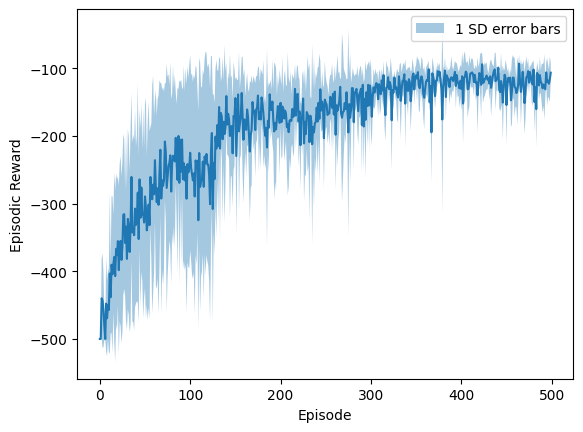

In [24]:
reward_avgs_va = np.array(reward_avgs_va)
reward_std_va = np.std(reward_avgs_va, axis=0)
reward_avgs_va = np.mean(reward_avgs_va, axis=0)
best = np.zeros(no_of_eps)
regret = np.sum(best-reward_avgs_va)
print(f"Acrobot regret = {regret}")

plt.figure()
plt.plot(reward_avgs_va)
plt.fill_between(np.array(range(no_of_eps)), reward_avgs_va - reward_std_va, reward_avgs_va + reward_std_va, alpha=0.4, label='1 SD error bars')
plt.xlabel('Episode')
plt.ylabel('Episodic Reward')
plt.legend()
plt.savefig('vanilla_acrobot')
plt.show()

In [25]:
reward_avgs_ba = []

for i in [0,1,4,5,6]:
    seed = i
    env = gym.make('Acrobot-v1')
    # env.seed(0)
    agent = ReinforceAgentT2(env)
    # torch.autograd.set_detect_anomaly(True)
    reward = train(env, agent, num_episodes=no_of_eps, seed = i)
    reward_avgs_ba.append(np.array(reward))

Episode 0	Average Score: -500.00
Episode 20	Average Score: -327.55
Episode 40	Average Score: -141.35
Episode 60	Average Score: -118.00
Episode 80	Average Score: -105.45
Episode 100	Average Score: -106.85
Episode 120	Average Score: -123.05
Episode 140	Average Score: -118.15
Episode 160	Average Score: -119.35
Episode 180	Average Score: -108.70
Episode 200	Average Score: -116.85
Episode 220	Average Score: -128.00
Episode 240	Average Score: -120.70
Episode 260	Average Score: -135.95
Episode 280	Average Score: -140.00
Episode 300	Average Score: -129.40
Episode 320	Average Score: -117.60
Episode 340	Average Score: -133.50
Episode 360	Average Score: -104.70
Episode 380	Average Score: -124.00
Episode 400	Average Score: -103.60
Episode 420	Average Score: -94.15
Episode 440	Average Score: -108.15
Episode 460	Average Score: -109.30
Episode 480	Average Score: -110.45
Episode 0	Average Score: -500.00
Episode 20	Average Score: -316.75
Episode 40	Average Score: -199.05
Episode 60	Average Score: -156.

Acrobot regret = 67496.4


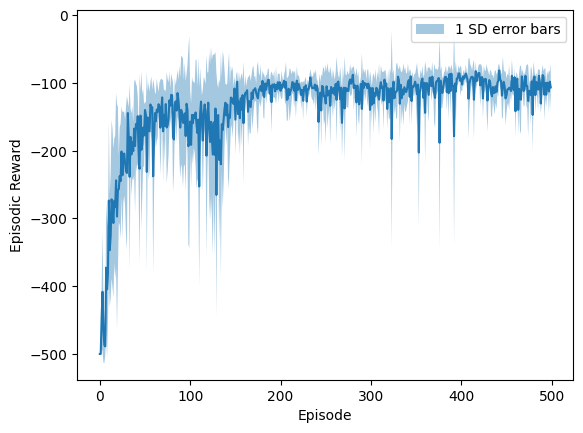

In [26]:
reward_avgs_ba = np.array(reward_avgs_ba)
reward_std_ba = np.std(reward_avgs_ba, axis=0)
reward_avgs_ba = np.mean(reward_avgs_ba, axis=0)
best = np.zeros(no_of_eps)
regret = np.sum(best-reward_avgs_ba)
print(f"Acrobot regret = {regret}")

plt.figure()
plt.plot(reward_avgs_ba)
plt.fill_between(np.array(range(no_of_eps)), reward_avgs_ba - reward_std_ba, reward_avgs_ba + reward_std_ba, alpha=0.4, label='1 SD error bars')
plt.xlabel('Episode')
plt.ylabel('Episodic Reward')
plt.legend()
plt.savefig('baseline_acrobot')
plt.show()

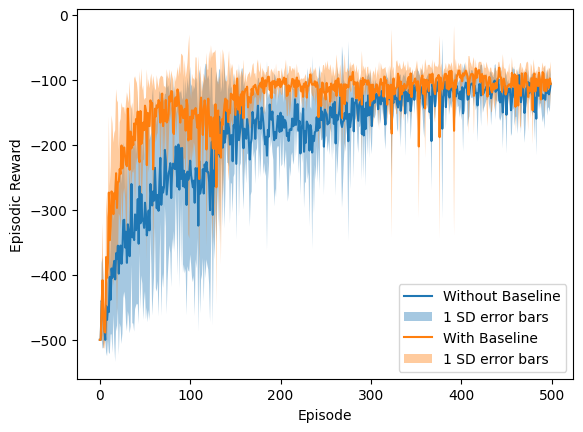

In [27]:
plt.figure()
plt.plot(reward_avgs_va, label = "Without Baseline")
plt.fill_between(np.array(range(no_of_eps)), reward_avgs_va - reward_std_va, reward_avgs_va + reward_std_va, alpha=0.4, label='1 SD error bars')
plt.plot(reward_avgs_ba, label = "With Baseline")
plt.fill_between(np.array(range(no_of_eps)), reward_avgs_ba - reward_std_ba, reward_avgs_ba + reward_std_ba, alpha=0.4, label='1 SD error bars')
plt.xlabel('Episode')
plt.ylabel('Episodic Reward')
plt.legend()
plt.savefig('baseline_acrobot_same_hyperparams')
plt.show()